In [1]:
from IPython import get_ipython
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file
from skimage.segmentation import find_boundaries

from stardist import edt_prob, star_dist, fill_label_holes
from stardist import random_label_cmap, draw_polygons, ray_angles

from stardist.nms import _non_maximum_suppression_old as non_maximum_suppression
from stardist.geometry import _dist_to_coord_old as dist_to_coord
from stardist.geometry import _polygons_to_label_old as polygons_to_label

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, gputools_available
from stardist.matching import matching_dataset
np.random.seed(42)
lbl_cmap = random_label_cmap()



import torch
torch.cuda.current_device()

ModuleNotFoundError: No module named 'csbdeep'

In [2]:
import sys
#bs = int(sys.argv[1])
#number_of_epochs = int(sys.argv[2])
bs =4

# # Data
# 
# The file `dsb2018.zip` contains the train and test images with associated ground truth labels as used in [our paper](https://arxiv.org/abs/1806.03535).
# They are a subset of the `stage1_train` images from the Kaggle 2018 Data Science Bowl, which are [available in full](https://data.broadinstitute.org/bbbc/BBBC038/) from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/).

X = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/train/images/*.tif'))
Y = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/train/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))



X_v = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/validation/images/*.tif'))
Y_v = sorted(glob('/scicore/home/pissal00/ercan0000/220310_training/stardist/ground_truth/validation/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X_v, Y_v))



X = list(map(imread,X))
Y = list(map(imread,Y))



X_v = list(map(imread,X_v))
Y_v = list(map(imread,Y_v))




i = min(2, len(X)-1)
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (2,3)
img = img if img.ndim==2 else img[...,:3]


n_rays = 32
prob = edt_prob(lbl)
dist = star_dist(lbl, n_rays)


# Convert star-convex distances to coordinates:


coord = dist_to_coord(dist)


# Perform non-maximum suppression to retain one polygon for each instance:


points = non_maximum_suppression(coord, prob, prob_thresh=0.5)


# Convert polygons to label image:


labels = polygons_to_label(coord, prob, points)


#  








import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D



#n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
n_channel = 3


axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()
    
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
X_v = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X_v)]
Y_v = [fill_label_holes(y) for y in tqdm(Y_v)]



X_val, Y_val = [X_v[i] for i in  range(0,len(X_v))]  , [Y_v[i] for i in range(0,len(Y_v))]
X_trn, Y_trn = [X[i] for i in range(0,len(X))]  , [Y[i] for i in range(0,len(Y))]



print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))






# # Configuration


print(Config2D.__doc__)

# we need to calculate steps of each epoch acording to batch size

# first calculate tilesize on QuPath
tile_size = 7246

batch_size = bs
bsstr = str(batch_size)
#for the augmentation factor
Multiply_dataset_by = 2

#total epochs
number_of_epochs = 10


#final calculation
number_of_steps = int((tile_size/batch_size)+1)
augmentation_factor = Multiply_dataset_by
number_of_steps = number_of_steps * augmentation_factor

# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = True and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = True,
    n_channel_in = n_channel,
    train_batch_size = batch_size,
    train_steps_per_epoch = number_of_steps,
    train_epochs = number_of_epochs,
)
print(conf)
vars(conf)



from csbdeep.utils.tf import limit_gpu_memory
# adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
limit_gpu_memory(0.8)

In [3]:
ModelName="stardist_jupyter"
model = StarDist2D(conf, name=ModelName, basedir='/scicore/home/pissal00/ercan0000/220310_training/stardist/output/models')




def random_fliprot(img, mask): 
    assert img.ndim>=mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y



# plot some augmented examples
img, lbl = X[0],Y[0]


# # Tensorboard activate
# open port with editing the jupyter one. change port no with '6006'
# run this in the terminal
# tensorboard --logdir=/scicore/home/pissal00/ercan0000/Stardist211104/


import torch
torch.cuda.current_device()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Using default values: prob_thresh=0.5, nms_thresh=0.4.


0

In [6]:
model.load_weights(name="weights_best.h5")

In [8]:
# model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)



model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  75%|███████▌  | 15/20 [05:47<01:55, 23.15s/it, 0.602 -> 0.833]


Using optimized values: prob_thresh=0.583648, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.5836481663382926, 'nms': 0.3}

In [27]:
# # Evaluation and Detection Performance

# Besides the losses and metrics during training, we can also quantitatively evaluate the actual detection/segmentation performance on the validation data by considering objects in the ground truth to be correctly matched if there are predicted objects with overlap (here [intersection over union (IoU)](https://en.wikipedia.org/wiki/Jaccard_index)) beyond a chosen IoU threshold $\tau$.
# 
# The corresponding matching statistics (average overlap, accuracy, recall, precision, etc.) are typically of greater practical relevance than the losses/metrics computed during training (but harder to formulate as a loss function). 
# The value of $\tau$ can be between 0 (even slightly overlapping objects count as correctly predicted) and 1 (only pixel-perfectly overlapping objects count) and which $\tau$ to use depends on the needed segmentation precision/application.
# 
# Please see `help(matching)` for definitions of the abbreviations used in the evaluation below and see the Wikipedia page on [Sensitivity and specificity](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) for further details.


# First predict the labels for all validation images:


Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]


100%|██████████| 24/24 [00:33<00:00,  1.38s/it]


In [25]:


def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl, cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()



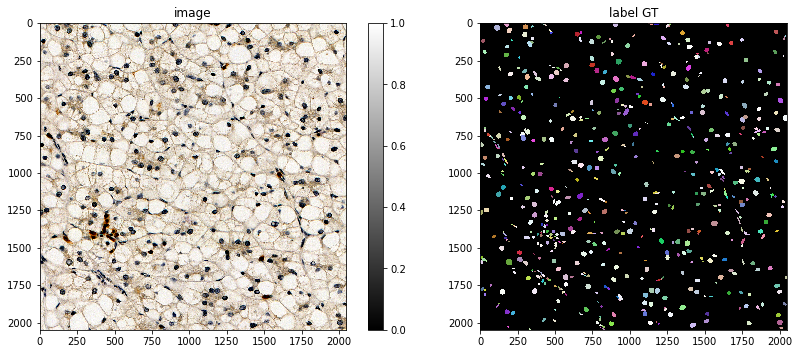

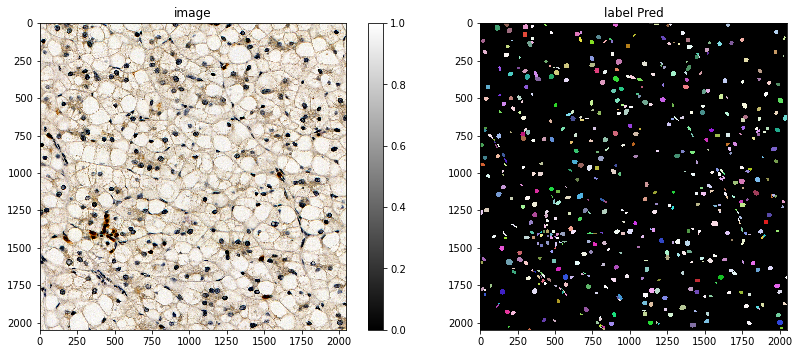

In [28]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred")


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:00<00:05,  4.02it/s]

  8%|▊         | 2/24 [00:00<00:06,  3.15it/s]

 12%|█▎        | 3/24 [00:01<00:08,  2.59it/s]

 17%|█▋        | 4/24 [00:01<00:09,  2.22it/s]

 21%|██        | 5/24 [00:02<00:07,  2.68it/s]

 29%|██▉       | 7/24 [00:02<00:06,  2.78it/s]

 33%|███▎      | 8/24 [00:03<00:06,  2.64it/s]

 38%|███▊      | 9/24 [00:03<00:05,  2.77it/s]

 42%|████▏     | 10/24 [00:03<00:04,  2.88it/s]

 46%|████▌     | 11/24 [00:03<00:03,  3.30it/s]

 54%|█████▍    | 13/24 [00:04<00:02,  4.04it/s]

 58%|█████▊    | 14/24 [00:04<00:02,  4.27it/s]

 62%|██████▎   | 15/24 [00:04<00:02,  4.36it/s]

 67%|██████▋   | 16/24 [00:04<00:01,  4.21it/s]

 71%|███████   | 17/24 [00:05<00:01,  4.00it/s]

 75%|███████▌  | 18/24 [00:05<00:01,  4.01it/s]

 79%|███████▉  | 19/24 [00:05<00:01,  4.20it/s]

 83%|████████▎ | 20/24 [00:05<00:00,  4.36it/s]

 88%|████████▊ | 21/24 [00:06<00:00,  4.37it/s

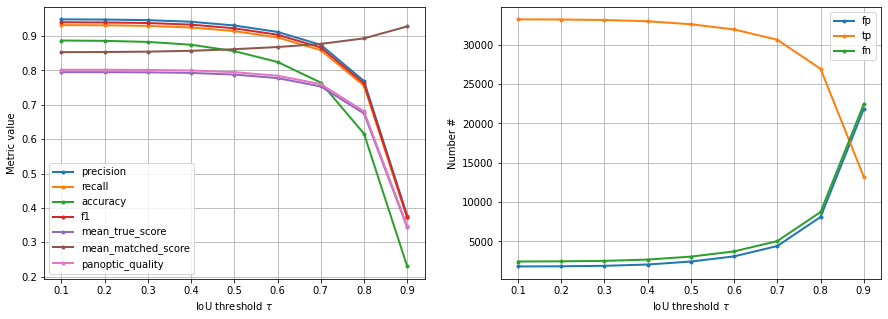

In [29]:
# Plot a GT/prediction example 



# Choose several IoU thresholds $\tau$ that might be of interest and for each compute matching statistics for the validation data.


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=True) for t in tqdm(taus)]







stats[taus.index(0.5)]



stats[taus.index(0.3)]



stats[taus.index(0.2)]

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();
#plt.savefig('/scicore/home/pissal00/ercan0000/220310_training/stardist/output/plot/'+bsstr+'.png')
#clear_pyplot_memory()


# Example: Print all available matching statistics for $\tau=0.5$

# Plot the matching statistics and the number of true/false positives/negatives as a function of the IoU threshold $\tau$. 

In [7]:
# # Export


ModelPath="/scicore/home/pissal00/ercan0000/220310_training/stardist"
exportName="stardist_export_"+bsstr
Export = ModelPath+exportName
model.export_TF(fname = Export)


NMS threshold = 0.3:   0%|          | 0/20 [00:05<?, ?it/s]


KeyboardInterrupt: 